In [75]:
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.plot import plotting_extent
from shapely.geometry import Polygon, mapping
from rasterio.mask import mask
from PIL import Image, ImageDraw
from os.path import join
import descartes

import earthpy.spatial as es
import earthpy.plot as ep
import earthpy.clip as ec
import earthpy.mask as em

In [22]:
from platform import python_version
print(python_version())

3.7.1


In [23]:
# local paths
path_data = r'/Volumes/other/datasets_and_ML/UNOSAT_Challenge/Train_Dataset'
area = 'Mosul_2015'
path_file = r's1tiling_S1A_IW_GRDH_1SDV_20150108T030926_20150108T030951_004074_004EC3_B908/38SLF/s1a_38SLF_vh_DES_20150108t030926.tif'
shape_file = r'38SLF_Mosul.shp'

img_raster = join(path_data, area, path_file)
shp = join(path_data, area, shape_file)
output = join(r'/Volumes/other/datasets_and_ML/UNOSAT_Challenge/output_test', 'mosul_test.tif')

### shape file

https://www.earthdatascience.org/workshops/gis-open-source-python/intro-vector-data-python/

In [24]:
jer_plot_locations = gpd.read_file(shp)

In [25]:
jer_plot_locations.head(), jer_plot_locations.total_bounds

(    DN                                           geometry
 0  255  POLYGON ((43.77908781084064 37.03939453669721,...
 1  255  POLYGON ((43.75411494257608 37.03903521485169,...
 2  255  POLYGON ((43.75303697703948 37.0389453843903, ...
 3  255  POLYGON ((43.73596918937665 37.03885555392893,...
 4  255  POLYGON ((43.78259119883458 37.03948436715859,...,
 array([42.75627818, 36.04056964, 43.99737583, 37.03948437]))

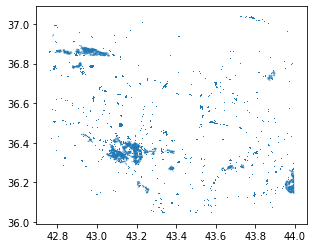

In [26]:
jer_plot_locations.plot()

In [ ]:
# to numpy array


### raster file

In [27]:
# open raster data
raster_dem = rio.open(img_raster)
# optional - view spatial extent
raster_dem.bounds

BoundingBox(left=300000.0, bottom=3990240.0, right=409790.0, top=4100040.0)

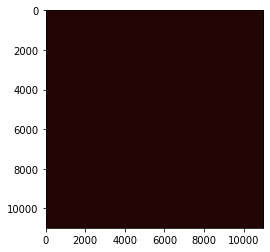

In [32]:
# plot the dem using rasterio and matpotlib
src = rio.open(img_raster)
plt.imshow(src.read(1), cmap='pink')
plt.show()

In [33]:
# read in all of the data without specifying a band
with rio.open(img_raster) as src:
    # convert / read the data into a numpy array:
    mosul_dem_im = src.read(masked= False)
    sjer_ext = rio.plot.plotting_extent(src)

# view array shape -- notice that you have 3 dimensions below
print(mosul_dem_im.shape)

(1, 10980, 10979)


In [35]:
mosul_first = mosul_dem_im[0]
mosul_first

array([[0.02447255, 0.01192943, 0.0088699 , ..., 0.        , 0.        ,
        0.        ],
       [0.029115  , 0.02159826, 0.01464731, ..., 0.        , 0.        ,
        0.        ],
       [0.02425862, 0.02407516, 0.01502362, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.02027426, 0.00911957, 0.01091624, ..., 0.04802645, 0.05474043,
        0.03748141],
       [0.02854771, 0.01546318, 0.00565862, ..., 0.0806036 , 0.07942985,
        0.04591966],
       [0.02773171, 0.01445956, 0.00773818, ..., 0.06088783, 0.07478052,
        0.04347003]], dtype=float32)

In [ ]:
mosul_slice = mosul_first[100:300,100:300]

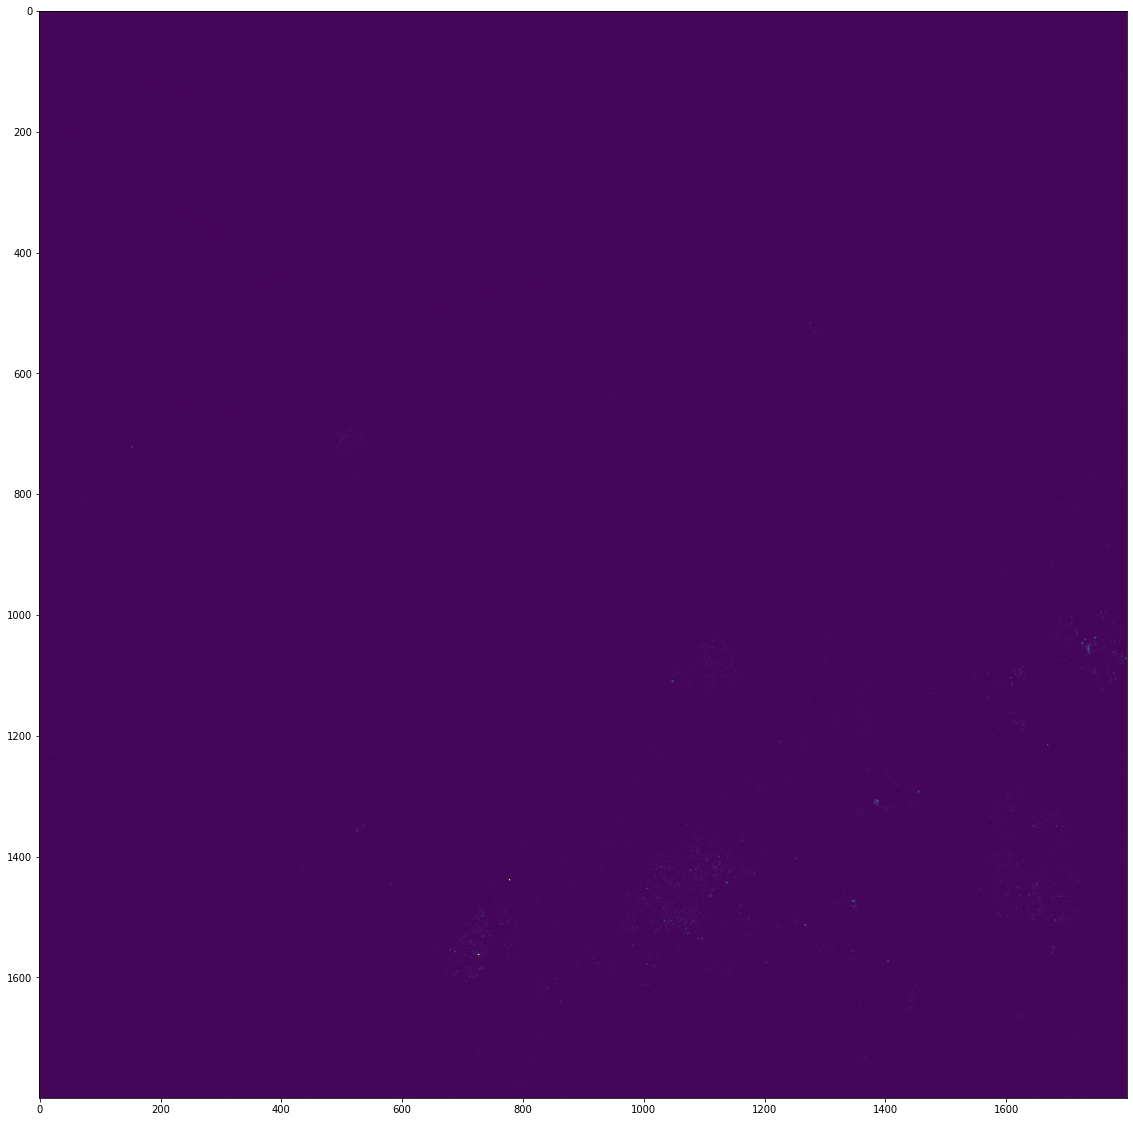

In [51]:
#try Matplotlib
n1 = 7000
n2 = 8800
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(mosul_first[n1:n2,n1:n2],  interpolation='nearest')

plt.show()

In [37]:
#try PIL
img = Image.fromarray(1 - mosul_first[n1:n2,n1:n2])
img.show()

## visualize with earthpy

see: https://earthpy.readthedocs.io/en/latest/gallery_vignettes/plot_rgb.html

###  4 bands:

In [54]:
band1 = join(path_data, area,'s1tiling_S1A_IW_GRDH_1SDV_20150108T030926_20150108T030951_004074_004EC3_B908/38SLF/s1a_38SLF_vh_DES_20150108t030926.tif')
band2 = join(path_data, area,'s1tiling_S1A_IW_GRDH_1SDV_20150426T030931_20150426T030956_005649_0073E6_2DFA/38SLF/s1a_38SLF_vh_20150426.tif')
band3 = join(path_data, area,'s1tiling_S1A_IW_GRDH_1SDV_20150812T030933_20150812T030958_007224_009E1D_B70E/38SLF/s1a_38SLF_vh_DES_20150812t030933.tif')
band4 = join(path_data, area,'s1tiling_S1A_IW_GRDH_1SDV_20151222T030932_20151222T030957_009149_00D2A0_F04A/38SLF/s1a_38SLF_vh_DES_20151222t030932.tif')


In [61]:
# Get list of bands and sort by ascending band number
bands = [band1, band2, band3, band4]

# Create image stack and apply nodata value for Landsat
arr_st, meta = es.stack(bands, nodata=-9999)

In [62]:
meta

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 10979, 'height': 10980, 'count': 4, 'crs': CRS.from_epsg(32638), 'transform': Affine(10.0, 0.0, 300000.0,
       0.0, -10.0, 4100040.0), 'tiled': False, 'interleave': 'band'}

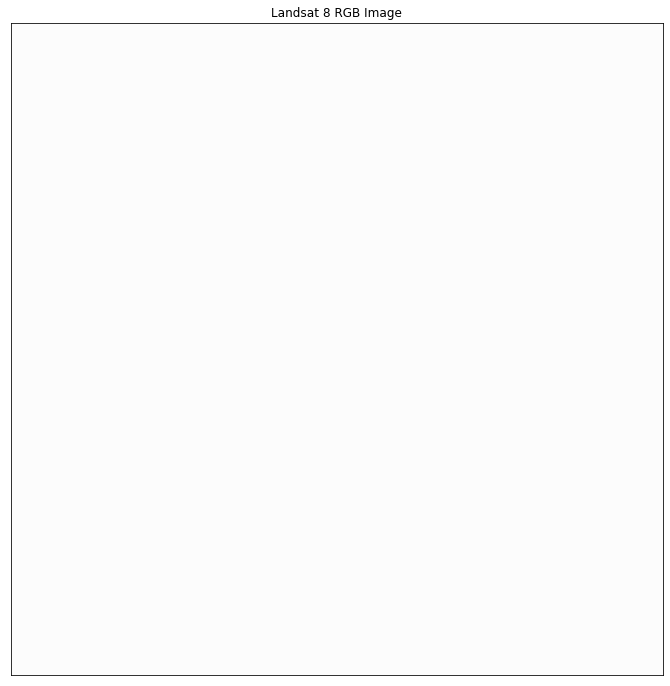

In [63]:
# Create figure with one plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot red, green, and blue bands, respectively
ep.plot_rgb(arr_st, rgb=(3, 2, 1, 0), ax=ax, title="Landsat 8 RGB Image")
plt.show()



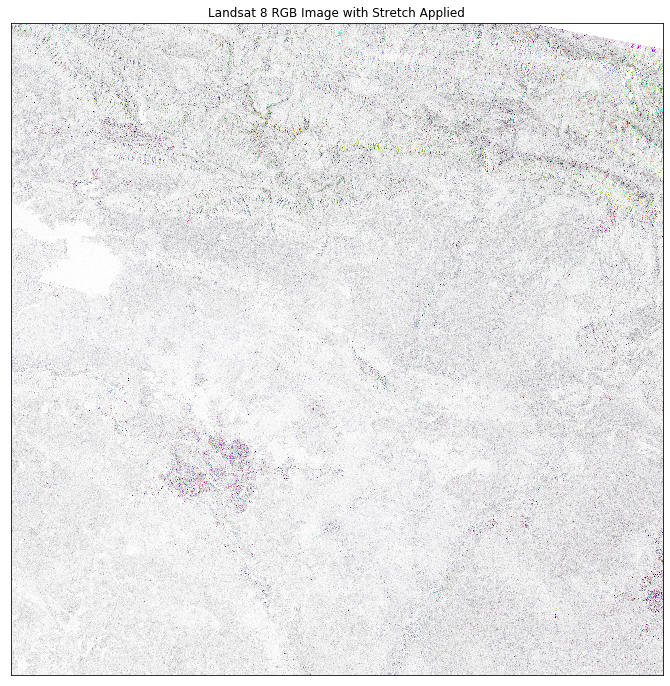

In [64]:
# Create figure with one plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot bands with stretched applied
ep.plot_rgb(
    arr_st,
    rgb=(3, 2, 1, 0),
    ax=ax,
    stretch=True,
    str_clip=0.5,
    title="Landsat 8 RGB Image with Stretch Applied",
)
plt.show()

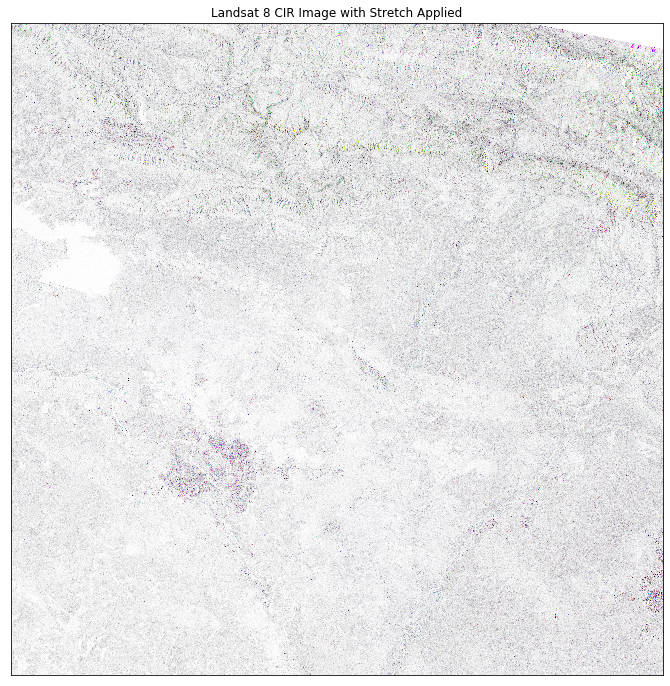

In [66]:
# Create figure with one plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot NIR, red, and green bands, respectively, with stretch
ep.plot_rgb(
    arr_st,
    rgb=(3, 2, 1, 0),
    ax=ax,
    stretch=True,
    str_clip=0.5,
    title="Landsat 8 CIR Image with Stretch Applied",
)
plt.show()

### together with shape 

In [ ]:
# Open polygon boundary using GeoPandas
bound = gpd.read_file(shp)

# Reproject boundary to match CRS of the Landsat images
with rio.open(bands[0]) as raster_crs:
    raster_profile = raster_crs.profile
    bound_utm13N = bound.to_crs(raster_profile["crs"])

In [ ]:
# Create figure with one plot
extent = plotting_extent(arr_st[0], raster_profile["transform"])

fig, ax = plt.subplots(figsize=(20,20))


# Plot boundary with high zorder for contrast
bound_utm13N.boundary.plot(ax=ax, color="black", zorder=10)

# Plot NIR, red, and green bands, respectively, with stretch
ep.plot_rgb(
    arr_st,
    rgb=(3, 2, 1, 0),
    ax=ax,
    stretch=True,
    str_clip=0.5,
    title="Landsat 8 CIR Image with Stretch Applied",
)

plt.show()